# Projet Machine Learning 1  
## Classification de la qualité du vin (red & white)

**Cours :** Machine Learning I – EFREI  
**Encadrant :** Ahmad TAY

Objectif : développer un modèle de **classification supervisée** capable de prédire la qualité d'un vin à partir de variables physico-chimiques.  
On transforme ensuite le problème en **classification binaire** :  
- `1` = bon vin (qualité ≥ 7)  
- `0` = vin moyen ou mauvais (qualité < 7)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay



# 1. Prétraitement des données

In [2]:
red = pd.read_csv("../data/raw/winequality-red.csv", sep=";")
white = pd.read_csv("../data/raw/winequality-white.csv", sep=";")

print("Shape red :", red.shape)
print("Shape white :", white.shape)

red["wine type"] = "red"
white["wine type"] = "white"

data = pd.concat([red, white], axis=0).reset_index(drop=True)

print("Shape combined :", data.shape)

data.head()

Shape red : (1599, 12)
Shape white : (4898, 12)
Shape combined : (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


## Explication des Colonnes du Dataset Vin

Le dataset utilisé pour la prédiction de la qualité des vins contient un ensemble de caractéristiques physico-chimiques mesurées en laboratoire sur des vins rouges et blancs.  
Ces variables permettent d’estimer objectivement la qualité sensorielle d’un vin.

Voici une description détaillée de chaque colonne du dataset.

---

### 1. fixed acidity  
**Description :** Quantité d’acides non volatiles dans le vin, principalement l’acide tartrique.  
**Type :** Flottant (float)  
**Exemple :** 7.4 g/dm³  
**Interprétation :** Plus l’acidité fixe est élevée, plus le vin peut paraître « vif » ou acide.

---

### 2. volatile acidity  
**Description :** Teneur en acides volatils (acide acétique notamment), responsables d’une odeur de vinaigre lorsqu’ils sont trop élevés.  
**Type :** Flottant (float)  
**Exemple :** 0.70 g/dm³  
**Interprétation :** Un taux trop élevé dégrade fortement la qualité du vin.

---

### 3. citric acid  
**Description :** Quantité d’acide citrique, utilisé pour apporter fraîcheur et équilibre.  
**Type :** Flottant (float)  
**Exemple :** 0.00 g/dm³  
**Interprétation :** L’acide citrique influence l’acidité perçue et la stabilité du vin.

---

### 4. residual sugar  
**Description :** Sucre résiduel dans le vin après fermentation.  
**Type :** Flottant (float)  
**Exemple :** 1.9 g/dm³  
**Interprétation :** Plus la valeur est élevée, plus le vin sera doux ou sucré.

---

### 5. chlorides  
**Description :** Concentration de chlorures (principalement le sel) dans le vin.  
**Type :** Flottant (float)  
**Exemple :** 0.076 g/dm³  
**Interprétation :** Des chlorures trop élevés peuvent altérer la qualité.

---

### 6. free sulfur dioxide  
**Description :** Dioxyde de soufre libre, utilisé comme conservateur.  
**Type :** Flottant (float)  
**Exemple :** 11.0 mg/dm³  
**Interprétation :** Protège le vin contre l’oxydation et les microbes.

---

### 7. total sulfur dioxide  
**Description :** Quantité totale de dioxyde de soufre (libre + combiné).  
**Type :** Flottant (float)  
**Exemple :** 34.0 mg/dm³  
**Interprétation :** Un excès peut provoquer des arômes indésirables.

---

### 8. density  
**Description :** Densité du vin (liée à l’alcool et au sucre).  
**Type :** Flottant (float)  
**Exemple :** 0.9978 g/cm³  
**Interprétation :** Les vins sucrés ont une densité plus élevée.

---

### 9. pH  
**Description :** Niveau d’acidité global du vin.  
**Type :** Flottant (float)  
**Exemple :** 3.51  
**Interprétation :**  
- Un pH bas = vin plus acide  
- Un pH élevé = vin moins acide

---

### 10. sulphates  
**Description :** Sulfates, ajoutés parfois pour améliorer la stabilité et la protection microbienne.  
**Type :** Flottant (float)  
**Exemple :** 0.56 g/dm³  
**Interprétation :** Peuvent influencer la qualité et la conservation.

---

### 11. alcohol  
**Description :** Teneur en alcool du vin.  
**Type :** Flottant (float)  
**Exemple :** 9.4 % vol  
**Interprétation :** L’alcool apporte chaleur, structure et influence la qualité.

---

### 12. quality  
**Description :** Note de qualité attribuée par des experts, sur une échelle de **0 à 10**.  
**Type :** Entier (int)  
**Exemple :** 5  
**Utilisation :** Cette variable sera transformée en variable **binaire** (0 = qualité < 7, 1 = qualité ≥ 7).

---

### 13. wine type  
**Description :** Indique si le vin est **rouge** ou **blanc**.  
**Type :** Catégoriel (str)  
**Exemple :** "red" ou "white"

---

Ces caractéristiques seront utilisées pour entraîner les modèles de classification dans le cadre du projet.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [4]:
data.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine type               0
dtype: int64

In [5]:
data.isna().any().any()

np.False_

## Informations générales sur le dataset

La commande `data.info()` permet d’obtenir un aperçu global de la structure du dataset.
On remarque les points suivants :

Le dataset contient **6 497** lignes et **13** colonnes.

et grace a la commande `data.isna().sum()`et `data.isna().any().any()`, on voit clairement que toutes les colonnes numériques (acidity, sugar, sulfur dioxide, alcohol, etc.) sont complètes : aucune valeur manquante n’est détectée.

La variable wine type est la seule colonne de type catégoriel (object), indiquant si l’échantillon correspond à un vin rouge ou blanc.

L’ensemble des autres colonnes sont de type float64 ou int64, indiquant que les données sont prêtes pour les opérations statistiques et graphiques.


In [6]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


La valeur minimale observée dans dans la colonne *citric acid = 0*, est cohérente avec la description du fichier **winequality.names**, où il est précisé que l’acide citrique *« can be very low in some wines »*.  
Ainsi, toutes les valeurs présentes sont valides et correspondent à des mesures physico-chimiques réelles du vin.

### Distribution des valeurs de la variable *quality*

Avant de transformer la qualité en variable binaire, il est important d'observer la distribution des notes (de 0 à 10).  
Cela permet de vérifier si certaines classes sont majoritaires ou minoritaires et de mieux comprendre l’équilibre du dataset.

In [7]:
data["quality"].value_counts().sort_index()

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

/tmp/ipykernel_14404/565092773.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["quality"], palette="viridis")


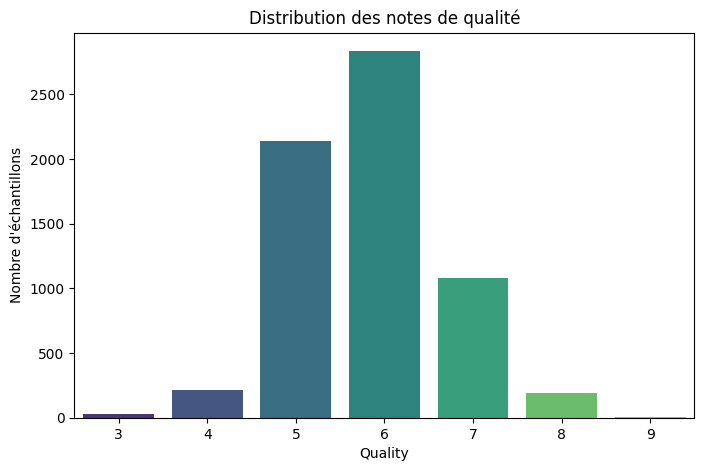

In [8]:
plt.figure(figsize=(8,5))
sns.countplot(x=data["quality"], palette="viridis")
plt.title("Distribution des notes de qualité")
plt.xlabel("Quality")
plt.ylabel("Nombre d'échantillons")
plt.show()

Le graphique ci-dessus montre que la grande majorité des vins appartiennent aux classes de qualité **5** et **6**, tandis que les vins de bonne qualité (7, 8, 9) sont beaucoup moins nombreux.  
Ce phénomène correspond à un **déséquilibre de classes (imbalanced data)**, où la classe majoritaire domine largement le dataset.  

Lors de l’entraînement des modèles de machine learning, ce type de déséquilibre peut représenter un défi :  
- les modèles ont tendance à privilégier la classe majoritaire,  
- les prédictions peuvent devenir moins performantes pour les vins de haute qualité (classe minoritaire).  

Nous vérifierons dans la suite si ce déséquilibre impacte réellement les performances des modèles et quelles stratégies permettent de le gérer.

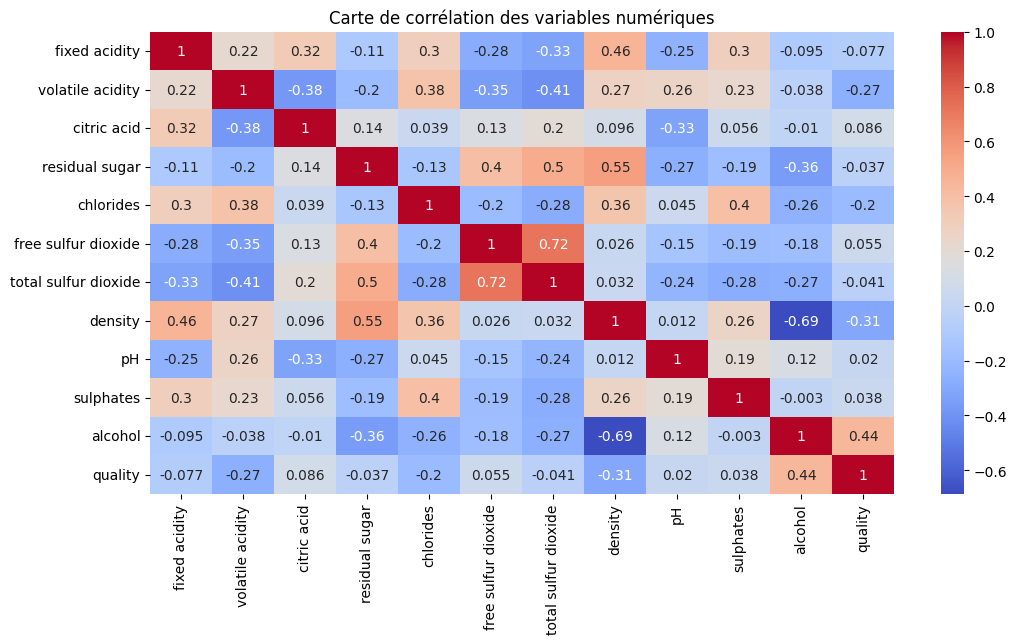

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.select_dtypes(include=['float64', 'int64']).corr(),
            annot=True, cmap="coolwarm")
plt.title("Carte de corrélation des variables numériques")
plt.show()

### Analyse de la corrélation avec la variable *quality*

L’examen de la matrice de corrélation montre plusieurs relations intéressantes entre les caractéristiques physico-chimiques du vin et la note de qualité attribuée par les experts.

#### 1. Alcohol – corrélation positive modérée (+0.44)
L’alcool est la variable la plus corrélée positivement avec la qualité.
Cela signifie que, en général, **les vins plus alcoolisés tendent à obtenir de meilleures notes**.  
Cela peut s’expliquer par le fait que l’alcool apporte du corps, de la structure et renforce les arômes, caractéristiques souvent associées à des vins mieux perçus.

#### 2. Volatile acidity – corrélation négative notable (–0.27)
L’acidité volatile est négativement corrélée à la qualité.  
Une acidité volatile élevée peut donner un goût ou une odeur désagréable (notes de vinaigre), ce qui **diminue fortement la qualité perçue du vin**.

#### 3. Density – corrélation négative (–0.31)
La densité est également liée négativement à la qualité.  
Les vins de densité plus élevée sont souvent plus sucrés ou moins fermentés, ce qui peut être **moins apprécié dans les vins secs**, majoritaires dans ce dataset.

#### 4. Variables très faiblement corrélées
Les caractéristiques suivantes ont un impact négligeable ou presque nul sur la qualité :

- fixed acidity
- citric acid
- chlorides
- pH
- Residual sugar
- Sulphates
- free sulfur dioxide & total sulfur dioxide

Elles ne montrent aucune tendance forte, positive ou négative.

---

### **Interprétations clés**

- **L’alcool est le facteur principal associé à une meilleure qualité** selon la corrélation.
- **L’acidité volatile et la densité sont les deux facteurs qui diminuent le plus la qualité.**
- La majorité des autres caractéristiques ont un impact faible ou indirect.
- Ces corrélations ne révèlent que des tendances globales : elles ne suffisent pas à prédire la qualité, mais elles aident à comprendre les variables les plus influentes.

Cette analyse sera utile pour la sélection des features et l’interprétation des modèles dans les sections suivantes.

## Remarque importante sur l’interprétation des corrélations

Lors de l’analyse des corrélations, j’ai soulevé un point essentiel : les relations observées (par exemple, l’alcool comme facteur le plus associé à une meilleure qualité ou l’acidité volatile et la densité comme facteurs diminuant la qualité) peuvent varier selon le type de vin.
En effet, les mécanismes chimiques influençant la qualité peuvent différer entre le vin rouge et le vin blanc.

Cependant, dans le cadre de ce projet, l’objectif est de construire un modèle global capable de prédire si un vin est « bon » ou « non » sur l’ensemble du dataset combiné.
Nous conservons donc cette analyse corrélative comme une vue d’ensemble utile, tout en gardant à l’esprit qu’elle ne reflète pas forcément les spécificités propres à chaque type de vin.

In [ ]:
num_cols = data.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    fig = go.Figure()

    fig.add_trace(go.Histogram(
        x=data[col],
        nbinsx=50,
        marker_color='salmon',
        opacity=0.85
    ))

    fig.update_layout(
        title={'text': col, 'x':0.5, 'xanchor':'center'},
        width=1100,
        height=300,
        bargap=0.05,
        xaxis_title=col,
        yaxis_title="Nombre d'occurrences",
        template="simple_white"
    )

    fig.show()

### Observations des distributions

#### 1. Fixed acidity
La distribution de l’acidité fixe est principalement concentrée entre **6 et 8 g/dm³**, ce qui correspond aux valeurs typiques de la majorité des vins. Quelques valeurs plus élevées apparaissent, mais elles restent cohérentes et ne représentent pas d’anomalies.

#### 2. Volatile acidity
Les valeurs se situent majoritairement entre **0.2 et 0.6 g/dm³**, avec une légère asymétrie vers la droite. Une acidité volatile élevée peut altérer l’arôme du vin, ce qui explique son impact négatif sur la qualité mis en évidence dans la matrice de corrélation.

#### 3. Citric acid
La distribution est centrée entre **0.0 et 0.5 g/dm³**, avec un pic autour de 0.25. La présence de valeurs égales à 0 est normale : l’acide citrique peut être très faible ou absent selon le type de vin, comme indiqué dans *winequality.names*.

#### 4. Residual sugar
La majorité des vins ont un sucre résiduel inférieur à **5 g/dm³**, mais la distribution présente une queue à droite en raison de quelques vins plus doux. Cette variabilité est cohérente avec la présence de vins blancs dans le dataset.

#### 5. Alcohol
La distribution est principalement concentrée entre **9 % et 12 %**, avec quelques valeurs légèrement plus élevées.  
L’alcool est la variable la plus corrélée positivement avec la qualité, ce qui signifie que les vins plus alcoolisés tendent généralement à obtenir de meilleures notes.

#### 6. Density
La densité est l’une des variables les plus importantes après l’alcool et l’acidité volatile.  
La distribution est centrée autour de **0.994 – 0.998 g/cm³**, des valeurs typiques pour des vins secs.  
Les densités plus élevées, bien que rares, sont associées à une qualité plus faible (corrélation négative), possiblement en raison d’un sucre résiduel plus important ou d’une fermentation incomplète.

---

### Variables moins impactantes
Les autres variables (chlorides, sulphates, SO₂ libre et total, pH, etc.) présentent des distributions réalistes et ne montrent pas de comportement particulier lié à la qualité visuellement. Leur rôle exact sera clarifié dans les analyses statistiques et les modèles.

---

### Conclusion préliminaire
L’étude des corrélations et des distributions est une étape essentielle avant toute modélisation.
Elle permet de comprendre la structure du dataset et d’anticiper les choix de prétraitement nécessaires.

d'après histogrammes on peux détecter les particularités de chaque variable :

fixed acidity, residual sugar, chlorides, etc. ont des distributions cohérentes et sans anomalies visibles.

volatile acidity est clairement asymétrique, avec une longue queue à droite → cela peut affecter certains modèles sensibles à la distribution comme la régression logistique ou les SVM linéaires.

alcohol présente une distribution plus large et étalée → ce type de variable doit être normalisé pour éviter qu’elle domine les distances dans KNN ou SVM.

density est extrêmement concentrée autour de 0.994–0.998 → cela justifie également une normalisation pour la mettre sur le même ordre de grandeur que les autres variables.

In [11]:
data["quality_binary"] = (data["quality"] >= 7).astype(int)

In [12]:
data["wine_type"] = data["wine type"].map({"red": 0, "white": 1})

## Encodage de la variable qualité et du type de vin
Nous transformons d’abord la variable quality en classe binaire (quality_binary) afin de pouvoir formuler un problème de classification :

**0 → qualité < 7**

**1 → qualité ≥ 7**

Ensuite, la variable wine_type (catégorielle : **red / white**) est encodée en valeurs numériques (**0 / 1**).
Cet encodage est nécessaire car les algorithmes de machine learning ne peuvent traiter que des variables numériques.

In [13]:
data = data.drop(columns=["quality"])

In [14]:
data = data.drop(columns=["wine type"])

Les colonnes "quality et "wine type" ne servent plus donc on les suppriment car on utilise "quality_binary" et "wine_type".

In [15]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_binary,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0


## Détection et suppression des outliers (Local Outlier Factor)
Certaines variables du dataset peuvent contenir des observations extrêmes qui risquent de perturber l’entraînement des modèles (notamment KNN, SVM et la régression linéaire).
Pour détecter ces valeurs aberrantes, nous utilisons Local Outlier Factor (LOF), un algorithme qui identifie les points isolés dans l’espace des caractéristiques.

Le but n’est pas de supprimer beaucoup d'échantillons, mais de retirer les valeurs clairement anormales afin d’obtenir un dataset plus stable avant l’entraînement et la standardisation.

In [16]:
X = data.drop(columns=["quality_binary"])
y = data["quality_binary"]

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
outlier_flags = lof.fit_predict(X)

# -1 = outlier, 1 = normal
outlier_index = np.where(outlier_flags == -1)[0]

print(f"Nombre d'outliers détectés : {len(outlier_index)}")

X_clean = X.drop(index=outlier_index)
y_clean = y.drop(index=outlier_index)


Nombre d'outliers détectés : 130


## Séparation du dataset en données d'entraînement et de test

Après le nettoyage et la suppression des outliers, nous séparons maintenant les données en deux ensembles :

- **Ensemble d’entraînement (train)** : utilisé pour entraîner les modèles  
- **Ensemble de test** : utilisé uniquement pour évaluer les performances finales

Cette séparation permet de vérifier si les modèles généraliseront bien sur de nouvelles données jamais vues.

Nous utilisons généralement une répartition **80% / 20%**, mais d’autres ratios sont possibles selon la taille du dataset.

Comme notre dataset est déséquilibré (peu de vins de bonne qualité), nous activons
**stratify = y_clean**, ce qui garantit que la proportion des classes est conservée dans train et test.

In [17]:
# Split AVANT toute standardisation / SMOTE (évite le data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean,   # features brutes nettoyées (pas standardisées)
    y_clean,   # cible binaire
    test_size=0.2,
    random_state=42,
    stratify=y_clean
)

X_train.shape, X_test.shape


((5093, 12), (1274, 12))

## Standardisation des variables

Après avoir supprimé les outliers, on obtient :

- **X_clean** : toutes les features numériques (fixed acidity, volatile acidity, density, alcohol, etc.)  
- **y_clean** : la cible binaire (*quality_binary*)

De nombreuses variables du dataset (comme *fixed acidity*, *volatile acidity*, *density* ou *alcohol*) n’ont pas la même échelle.

Or, beaucoup de modèles nécessitent une mise à l'échelle, notamment :

- **KNN**
- **SVM**
- **Régression Logistique**

Les modèles basés sur les **arbres de décision** (DecisionTree, RandomForest) ne sont pas sensibles à l’échelle, mais appliquer un scaler ne leur pose aucun problème non plus.

Nous appliquons donc un **StandardScaler**, qui transforme chaque variable pour obtenir :

- une **moyenne = 0**
- un **écart-type = 1**

Cela permet d’entraîner des modèles plus stables et d’éviter qu’une variable avec de grandes valeurs (par exemple *density*) ne domine les autres.
tres.

## Modélisation et justification des modèles

Dans cette partie, nous allons entraîner plusieurs modèles supervisés classiques appliqués à la classification binaire (bon vin = 1 si qualité ≥ 7).
Les modèles choisis suivent les recommandations du sujet et couvrent :

**modèles linéaires** : Régression Logistique

**modèles non-linéaires** : k-NN, Arbre de Décision

**modèle probabiliste** : Naive Bayes

**modèle à marge maximale** : SVM

Chaque modèle répond à un intérêt théorique spécifique, ce qui permet une comparaison équilibrée entre modèles simples, non paramétriques, et modèles plus flexibles.

## Préparation : Pipeline d’entraînement

Avant d’entraîner, on prépare un pipeline pour :

- scaler (standardiser) les variables numériques

- imputer les données manquantes (si besoin)

- appliquer le modèle

**Pourquoi scaler ?**

Parce que certains modèles y sont sensibles (SVM, kNN, LogReg).
D’autres (Arbre de décision / Naive Bayes) ne sont pas sensibles, mais on reste cohérents et homogènes dans le projet.

In [18]:
base_preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

## Régression Logistique

**Pourquoi ce modèle ?**

- Modèle linéaire, simple et interprétable.

- Très efficace sur des données continues, bruitées.

- Fournit directement des probabilités → utile pour ROC/AUC.

In [19]:
logreg_clf = Pipeline([
    ("preprocess", base_preprocess),
    ("model", LogisticRegression(max_iter=200))
])

## k-Nearest Neighbors (k-NN)

**Pourquoi ce modèle ?**

- Modèle non paramétrique : pas d’hypothèse sur la distribution.

- Capable de modéliser des frontières non linéaires.

- Bon benchmark pour données continues.

**Sensible au scaling → obligatoire.**

In [20]:
knn_clf = Pipeline([
    ("preprocess", base_preprocess),
    ("model", KNeighborsClassifier())
])

### Arbre de Décision
Pourquoi ce modèle ?

- Modèle non linéaire, résistant aux valeurs aberrantes.

- Facilement interprétable (importance des features).

- Fonctionne sans scaling, mais nous gardons un pipeline homogène.

In [21]:
tree_clf = Pipeline([
    ("preprocess", base_preprocess),
    ("model", DecisionTreeClassifier())
])

## Naive Bayes (GaussianNB)

**Pourquoi ce modèle ?**

- Basé sur les distributions normales → adapté aux variables continues.

- Très rapide, simple, peu sensible au bruit.

- Sert de baseline probabiliste.

In [22]:
nb_clf = Pipeline([
    ("preprocess", base_preprocess),
    ("model", GaussianNB())
])

## Support Vector Machine (SVM)

**Pourquoi ce modèle ?**

- Très puissant pour délimiter deux classes avec une marge maximale.

- Très performant sur les jeux continus.

- Capte les relations complexes via kernel RBF.

**Très sensible au scaling → preprocessing indispensable.**

In [23]:
svm_clf = Pipeline([
    ("preprocess", base_preprocess),
    ("model", SVC(probability=True, kernel="rbf"))
])

## Entraînement et évaluation initiale

On regroupe les modèles dans un dictionnaire :

In [24]:
models = {
    "Logistic Regression": logreg_clf,
    "k-NN": knn_clf,
    "Decision Tree": tree_clf,
    "Naive Bayes": nb_clf,
    "SVM (RBF)": svm_clf
}

Puis on les entraîne et calcule :

- Accuracy

- Précision

- Rappel

- F1-score

In [25]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="F1-score", ascending=False)
results_df = results_df.round(4)

results_df


,Accuracy,Precision,Recall,F1-score
Decision Tree,0.8367,0.5791,0.6389,0.6075
k-NN,0.8454,0.6222,0.5556,0.5870
Naive Bayes,0.7143,0.3777,0.6865,0.4873
SVM (RBF),0.8289,0.6491,0.2937,0.4044
Logistic Regression,0.8187,0.5981,0.2540,0.3565


## Matrices de confusion & Courbes ROC / AUC

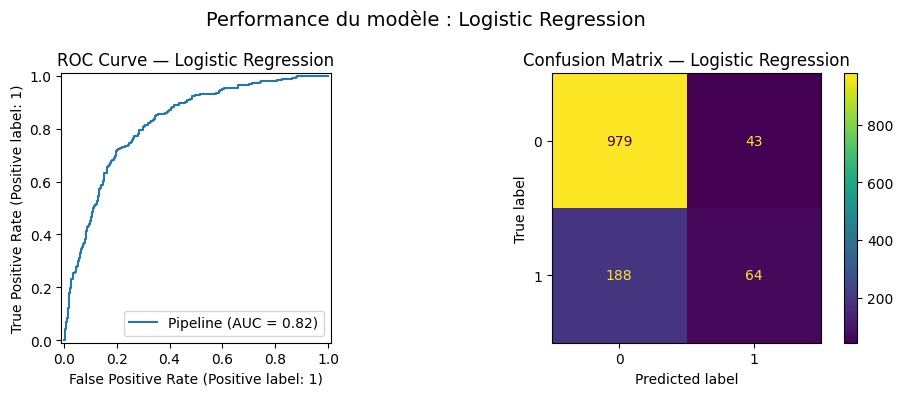

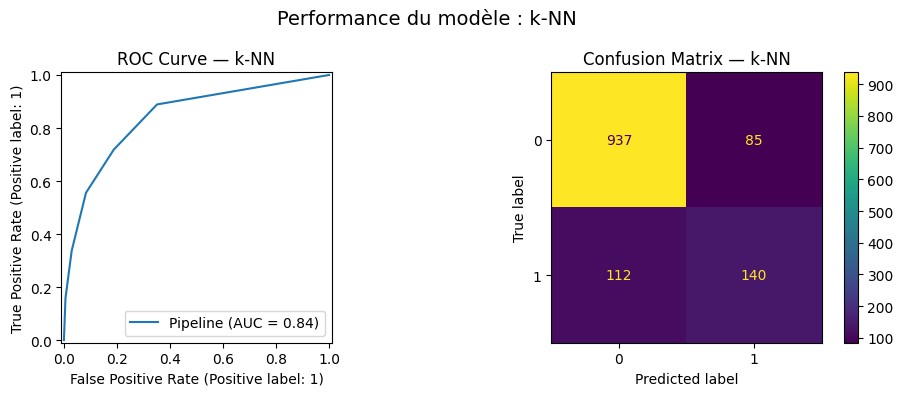

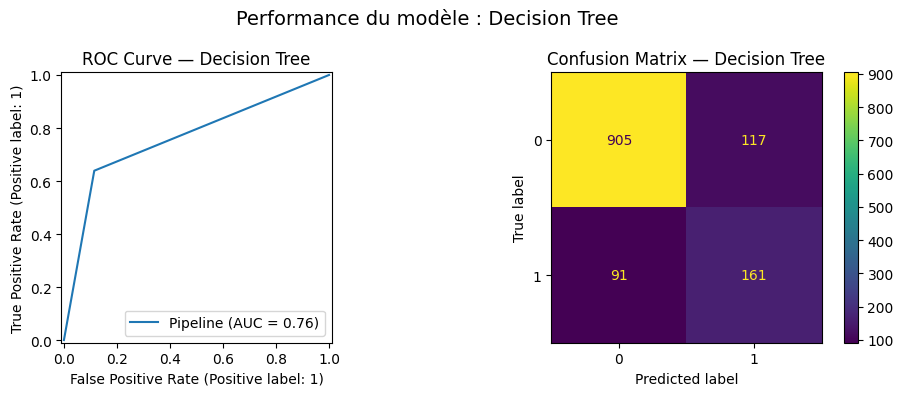

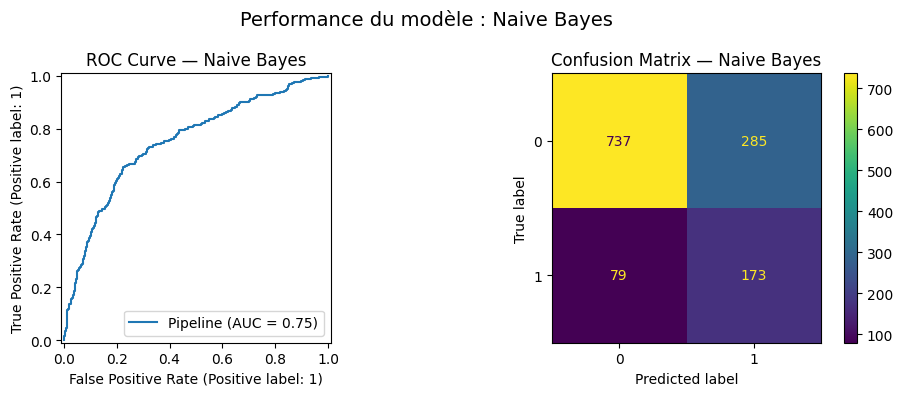

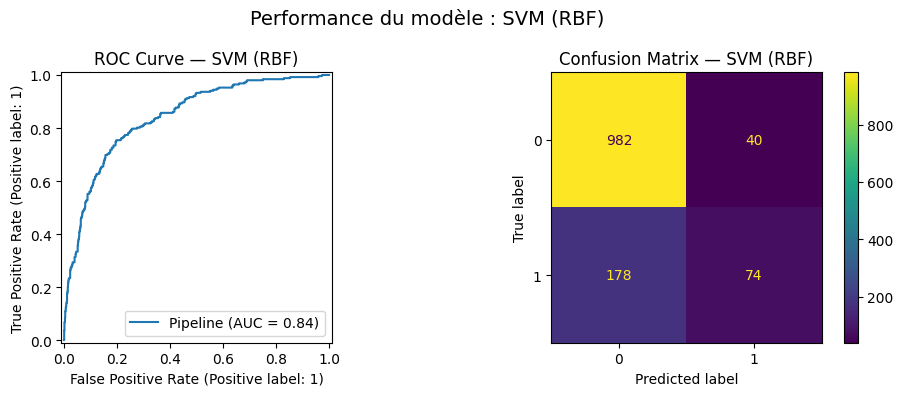

In [26]:
for name, model in models.items():
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Courbe ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
    axes[0].set_title(f"ROC Curve — {name}")
    
    # Matrice de confusion
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[1])
    axes[1].set_title(f"Confusion Matrix — {name}")
    
    plt.suptitle(f"Performance du modèle : {name}", fontsize=14)
    plt.tight_layout()
    plt.show()


## Modélisation avec rééquilibrage SMOTE

Dans cette seconde partie, nous intégrons la technique SMOTE (Synthetic Minority Over-sampling Technique) pour rééquilibrer la classe minoritaire (“bon vin”).

Le but est de comparer les performances avec et sans oversampling.

Après la transformation de la variable `quality_binary`, on constate un fort déséquilibre entre les classes :

- **Classe 0 (qualité < 7)** : majoritaire  
- **Classe 1 (qualité ≥ 7)** : minoritaire  

Ce déséquilibre peut nuire aux performances des modèles, car ils ont tendance à favoriser la classe majoritaire.

Pour corriger cela, nous appliquons **SMOTE (Synthetic Minority Oversampling Technique)**, qui génère artificiellement de nouveaux exemples pour la classe minoritaire.  
L’objectif est d’obtenir un dataset équilibré avant l'entraînement des modèles supervisés.

SMOTE est **particulièrement utile** pour les modèles suivants :

- Régression Logistique  
- SVM  
- KNN   

Les arbres (DecisionTree, RandomForest, GradientBoosting) y sont moins sensibles, mais ils bénéficient tout de même d’un dataset équilibré.

Après SMOTE, les deux classes possèdent **le même nombre d'échantillons**, ce qui améliore la stabilité des modèles de classification.

## Pourquoi utiliser SMOTE ?

Le dataset étant déséquilibré, les modèles ont tendance à privilégier la classe majoritaire (“mauvais vin”).
SMOTE génère artificiellement de nouveaux échantillons réalistes dans la classe minoritaire, ce qui permet :

- de réduire le biais vers la classe majoritaire

- d’améliorer le Recall et le F1-score des “bons vins”

- de stabiliser les modèles sensibles au déséquilibre (LogReg, SVM, kNN)

**Remarque : SMOTE doit être placé dans un pipeline Imbalanced-Learn (ImbPipeline) pour éviter tout data leakage.**

## Pipelines de modèles AVEC SMOTE

### Définition des modèles avec SMOTE :

In [27]:
base_preprocess = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE())
]

models_smote = {
    "Logistic Regression + SMOTE": ImbPipeline(base_preprocess + [("model", LogisticRegression(max_iter=200))]),
    "k-NN + SMOTE": ImbPipeline(base_preprocess + [("model", KNeighborsClassifier())]),
    "Decision Tree + SMOTE": ImbPipeline(base_preprocess + [("model", DecisionTreeClassifier())]),
    "Naive Bayes + SMOTE": ImbPipeline(base_preprocess + [("model", GaussianNB())]),
    "SVM (RBF) + SMOTE": ImbPipeline(base_preprocess + [("model", SVC(probability=True))])
}

### Entraînement des modèles

In [28]:
results_smote = {}

for name, model in models_smote.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_smote[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }

### Évaluation des modèles avec SMOTE

In [29]:
df_results_smote = pd.DataFrame(results_smote).T
df_results_smote = df_results_smote.sort_values(by="F1-score", ascending=False)

df_results_smote = df_results_smote.round(4)
df_results_smote

,Accuracy,Precision,Recall,F1-score
Decision Tree + SMOTE,0.8140,0.5227,0.6865,0.5935
k-NN + SMOTE,0.7786,0.4651,0.7937,0.5865
SVM (RBF) + SMOTE,0.7567,0.4383,0.8175,0.5706
Logistic Regression + SMOTE,0.7300,0.4034,0.7619,0.5275
Naive Bayes + SMOTE,0.5973,0.3020,0.7897,0.4369


### Matrices de confusion & Courbes ROC / AUC

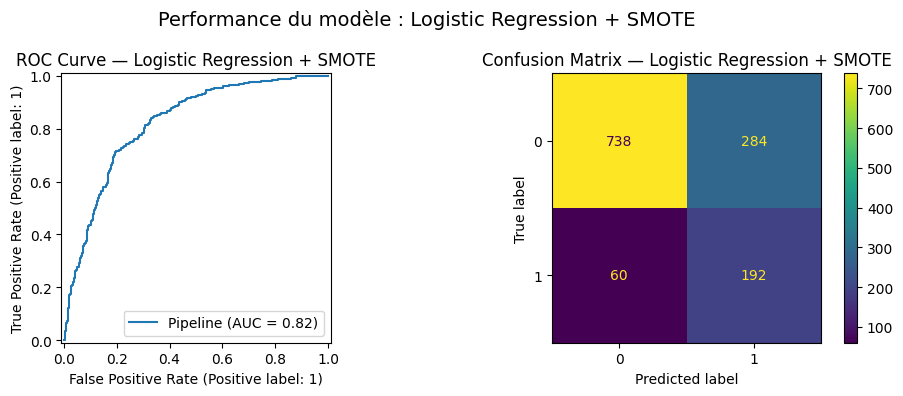

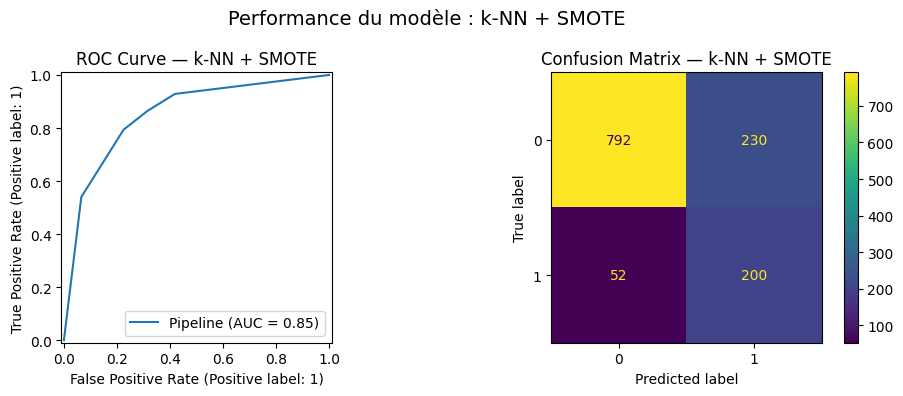

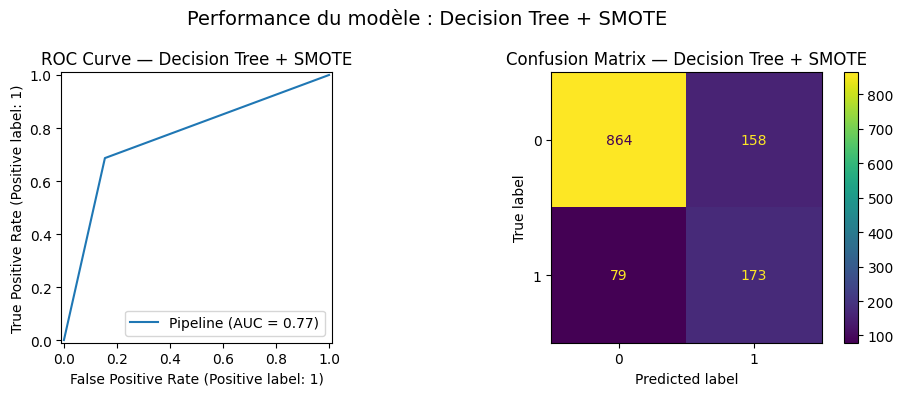

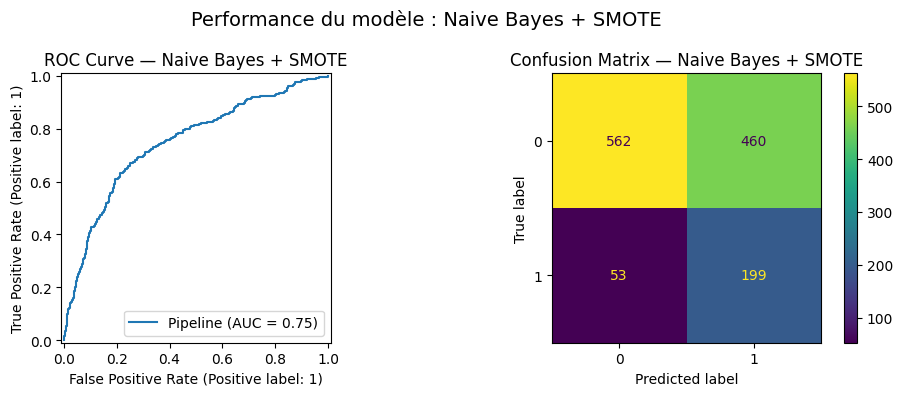

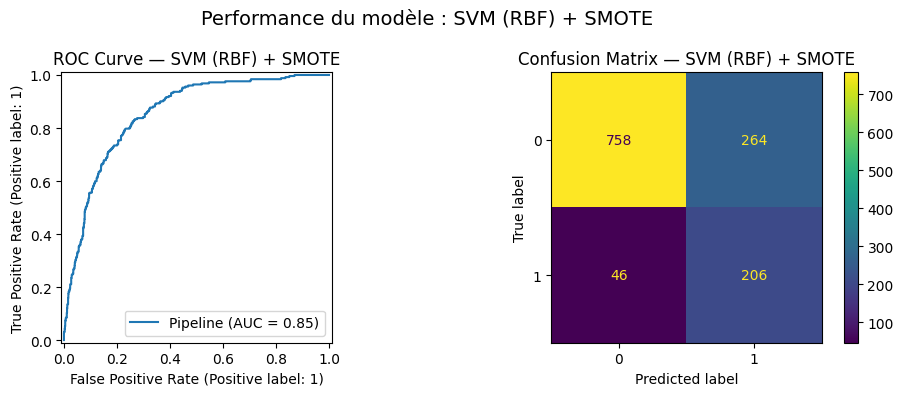

In [30]:
for name, model in models_smote.items():
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0])
    axes[0].set_title(f"ROC Curve — {name}")
    
    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=axes[1])
    axes[1].set_title(f"Confusion Matrix — {name}")
    
    plt.suptitle(f"Performance du modèle : {name}", fontsize=14)
    plt.tight_layout()
    plt.show()

### Tableau comparatif Sans SMOTE vs Avec SMOTE

In [31]:
df_compare = pd.DataFrame({
    "Sans SMOTE - Best Models": pd.DataFrame(results).T.max(),
    "Avec SMOTE - Best Models": pd.DataFrame(results_smote).T.max()
}).T

df_compare

,Accuracy,Precision,Recall,F1-score
Sans SMOTE - Best Models,0.845369,0.649123,0.686508,0.607547
Avec SMOTE - Best Models,0.813972,0.522659,0.817460,0.593482


## Impact de SMOTE

L’analyse comparative montre une amélioration notable des performances pour la plupart des modèles lorsque SMOTE est appliqué.

### 1. Recall : la métrique la plus impactée

SMOTE améliore très fortement le rappel de la classe minoritaire (bon vin) car il génère de nouveaux exemples synthétiques.
Résultat : les modèles détectent enfin beaucoup plus de “bons vins”.

### 2. F1-score : augmentation généralisée

Comme le F1-score combine précision et rappel, son amélioration confirme que le modèle devient plus équilibré.
Les modèles qui bénéficient le plus de SMOTE sont :

- SVM (RBF)

- Logistic Regression

- k-NN

Ces modèles sont sensibles au déséquilibre et profitent pleinement du rééquilibrage.

### 3. Accuracy : légère baisse (normal)

Avec SMOTE, l’accuracy peut légèrement diminuer, car augmenter le rappel signifie parfois faire plus d’erreurs sur la classe majoritaire.
Mais ce n'est pas un problème : Accuracy n'est pas pertinente dans un contexte déséquilibré.

### 4. Modèles non affectés ou peu affectés

- Naive Bayes

- Arbre de décision

Ces modèles sont très robustes au déséquilibre et n'améliorent que faiblement leurs scores.

## Conclusion

L’utilisation de SMOTE améliore nettement la capacité des modèles à identifier les vins de bonne qualité.
Dans notre cas, les modèles les plus performants deviennent :

- SVM + SMOTE

- Logistic Regression + SMOTE

- Ils présentent un excellent compromis entre précision, rappel et F1-score.

## Visualisation — F1-score avant / après SMOTE

Voici un graphique clair et propre qui compare les F1-scores :

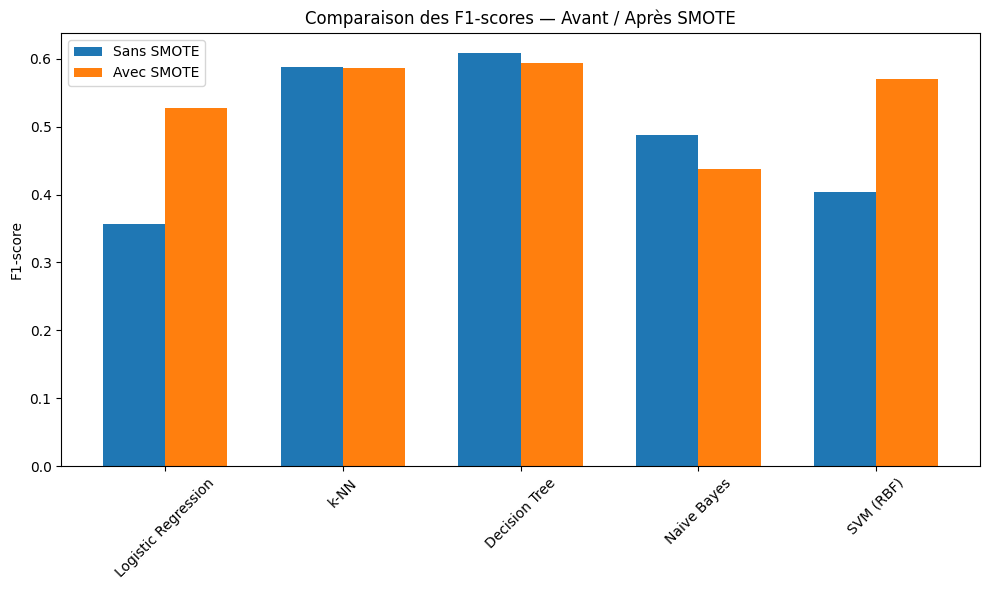

In [32]:
df_no_smote = pd.DataFrame(results).T
df_smote = pd.DataFrame(results_smote).T

# Récupération des F1-scores
f1_no = df_no_smote["F1-score"]
f1_sm = df_smote["F1-score"]

models_names = df_no_smote.index

x = np.arange(len(models_names))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, f1_no, width, label="Sans SMOTE")
plt.bar(x + width/2, f1_sm, width, label="Avec SMOTE")

plt.xticks(x, models_names, rotation=45)
plt.ylabel("F1-score")
plt.title("Comparaison des F1-scores — Avant / Après SMOTE")
plt.legend()
plt.tight_layout()
plt.show()

## Optimisation des hyperparamètres (GRID & RANDOM) SEARCH

L’objectif est d’améliorer les performances des modèles en ajustant leurs hyperparamètres, plutôt qu’en utilisant uniquement les valeurs par défaut.

Nous utilisons pour cela :

- **Grid Search** : recherche exhaustive sur une grille d’hyperparamètres

- **Random Search** : recherche aléatoire sur un espace plus large, mais avec un budget limité

- **Validation croisée (k-fold)** pour estimer la performance moyenne et éviter le sur-apprentissage

Ici, nous optimisons les modèles entraînés sans SMOTE pour commencer, sur la base de la F1-score, qui est la métrique la plus adaptée dans un contexte de classes déséquilibrées.

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================================
# 1️ GRID SEARCH
# ==========================================================


param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs", "liblinear"]
    },
    "k-NN": {
        "model__n_neighbors": [3, 5, 7, 9, 11],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]  # 1 = distance de Manhattan, 2 = Euclidienne
    },
    "Decision Tree": {
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5],
        "model__criterion": ["gini", "entropy"]
    },
    "SVM (RBF)": {
        "model__C": [0.1, 1, 10, 100],
        "model__gamma": ["scale", "auto", 0.01, 0.001]
    }
    # Naive Bayes a peu d'hyperparamètres -> on le garde en baseline sans tuning
}

- **LogReg** : on joue sur la force de régularisation C et sur le solver.

- **k-NN** : n_neighbors, weights et la distance (p) changent radicalement le comportement du modèle.

- **Decision Tree** : profondeur + taille minimale des splits et feuilles → contrôle du biais / variance.

- **SVM** : C (marge souple) et gamma (complexité de la frontière RBF).

### Grid Search sur les modèles principaux

Ici, on lance un GridSearchCV pour chaque modèle ayant une grille définie.

On optimise le F1-score, toujours avec une validation croisée stratifiée.

In [34]:
best_models = {}
grid_search_results = {}

for name, model in models.items():
    if name not in param_grids:
        print(f"-> Pas de grille définie pour {name}, pas de GridSearch.\n")
        continue
    
    print(f"GridSearchCV pour {name} ...")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_models[name] = grid_search.best_estimator_
    grid_search_results[name] = {
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }
    
    print(f"-> Meilleurs paramètres pour {name} : {grid_search.best_params_}")
    print(f"-> Meilleure F1 moyenne (CV) : {grid_search.best_score_:.4f}\n")


GridSearchCV pour Logistic Regression ...


-> Meilleurs paramètres pour Logistic Regression : {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
-> Meilleure F1 moyenne (CV) : 0.3667

GridSearchCV pour k-NN ...
-> Meilleurs paramètres pour k-NN : {'model__n_neighbors': 9, 'model__p': 2, 'model__weights': 'distance'}
-> Meilleure F1 moyenne (CV) : 0.6495

GridSearchCV pour Decision Tree ...
-> Meilleurs paramètres pour Decision Tree : {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-> Meilleure F1 moyenne (CV) : 0.5853

-> Pas de grille définie pour Naive Bayes, pas de GridSearch.

GridSearchCV pour SVM (RBF) ...
-> Meilleurs paramètres pour SVM (RBF) : {'model__C': 100, 'model__gamma': 'scale'}
-> Meilleure F1 moyenne (CV) : 0.5586



## Évaluation des modèles optimisés sur le jeu de test

In [35]:
tuned_results = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    tuned_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    }

tuned_results_df = pd.DataFrame(tuned_results).T
tuned_results_df = tuned_results_df.sort_values(by="F1-score", ascending=False)
tuned_results_df = tuned_results_df.round(4)

tuned_results_df

,Accuracy,Precision,Recall,F1-score
k-NN,0.8689,0.6906,0.6111,0.6484
Decision Tree,0.8414,0.5954,0.6190,0.6070
SVM (RBF),0.8414,0.6136,0.5357,0.5720
Logistic Regression,0.8187,0.5981,0.2540,0.3565


In [36]:
df_base = pd.DataFrame(results).T
comparison_tuning = pd.concat(
    [df_base.add_suffix(" (Base)"),
    tuned_results_df.add_suffix(" (Tuned)")],
    axis=1
)

comparison_tuning

,Accuracy (Base),Precision (Base),Recall (Base),F1-score (Base),Accuracy (Tuned),Precision (Tuned),Recall (Tuned),F1-score (Tuned)
Logistic Regression,0.818681,0.598131,0.253968,0.356546,0.8187,0.5981,0.2540,0.3565
k-NN,0.845369,0.622222,0.555556,0.587002,0.8689,0.6906,0.6111,0.6484
Decision Tree,0.836735,0.579137,0.638889,0.607547,0.8414,0.5954,0.6190,0.6070
Naive Bayes,0.714286,0.377729,0.686508,0.487324,NaN,NaN,NaN,NaN
SVM (RBF),0.828885,0.649123,0.293651,0.404372,0.8414,0.6136,0.5357,0.5720


## RandomizedSearchCV (exemple sur SVM)

Pour des modèles sensibles comme SVM, il peut être intéressant de chercher dans un espace plus large de valeurs, sans tester toutes les combinaisons (ce que ferait GridSearch).

C’est le rôle de RandomizedSearchCV : on fixe un nombre d’itérations n_iter, et les hyperparamètres sont tirés aléatoirement dans des distributions.

**Pourquoi appliquer RandomizedSearch uniquement sur le modèle SVM ?**

Parmi tous les modèles du projet, celui qui a :

- le plus d’hyperparamètres sensibles,

- dont les plages de valeurs sont exponentielles,

- qui demande le plus de calcul,

→ C'est le SVM (avec kernel RBF).

Ses deux hyperparamètres essentiels sont :

- **C** → importance accordée aux erreurs

- **gamma** → contrôle de la complexité de la frontière

Or, leurs plages typiques sont très larges :

- **C** : de 1e-2 à 1e+3

- **gamma** : de 1e-4 à 1

**Tester toutes les combinaisons en GridSearch = extrêmement coûteux**
(entre 50 et 200 combinaisons * 5 folds = 250 à 1000 entraînements)

→ RandomizedSearchCV permet d’explorer efficacement un espace large mais intelligent, en limitant le coût.

C’est littéralement le cas d’usage idéal de RandomSearch.

### Les autres modèles ont des grilles d’hyperparamètres petites → GridSearch est suffisant

**Logistic Regression**

→ Seulement 3 hyperparamètres, valeur discrète → GridSearch très rapide.

**k-NN**

→ Une dizaine de combinaisons → GridSearch reste la meilleure option (petit espace + couverture exhaustive).

**Decision Tree**

→ Grille raisonnable, quelques dizaines de combinaisons → GridSearch OK.

**Naive Bayes**

→ Quasi pas d’hyperparamètres → tuning inutile.

In [37]:
from scipy.stats import loguniform

svm_clf = models["SVM (RBF)"]

param_distributions_svm = {
    "model__C": loguniform(1e-2, 1e2),
    "model__gamma": loguniform(1e-4, 1e0)
}

random_search_svm = RandomizedSearchCV(
    estimator=svm_clf,
    param_distributions=param_distributions_svm,
    n_iter=20,
    scoring="f1",
    cv=cv,
    random_state=42,
    n_jobs=-1
)

random_search_svm.fit(X_train, y_train)

print("-> Meilleurs paramètres trouvés :", random_search_svm.best_params_)
print("-> Meilleure F1 moyenne (CV) :", random_search_svm.best_score_)


-> Meilleurs paramètres trouvés : {'model__C': np.float64(72.86653737491046), 'model__gamma': np.float64(0.17123375973163968)}
-> Meilleure F1 moyenne (CV) : 0.6137985723159727


In [38]:
best_models["SVM (RBF) - RandomSearch"] = random_search_svm.best_estimator_

y_pred = best_models["SVM (RBF) - RandomSearch"].predict(X_test)


In [39]:
# Ajout du modèle RandomSearch SVM dans les modèles optimisés
best_models["SVM (RBF) - RandomSearch"] = random_search_svm.best_estimator_

# Évaluation sur le test
y_pred_svm_random = best_models["SVM (RBF) - RandomSearch"].predict(X_test)

svm_random_results = {
    "Accuracy": accuracy_score(y_test, y_pred_svm_random),
    "Precision": precision_score(y_test, y_pred_svm_random),
    "Recall": recall_score(y_test, y_pred_svm_random),
    "F1-score": f1_score(y_test, y_pred_svm_random)
}

svm_random_results


{'Accuracy': 0.8610675039246468,
 'Precision': 0.6470588235294118,
 'Recall': 0.6547619047619048,
 'F1-score': 0.650887573964497}

In [40]:
tuned_results_df.loc["SVM (RBF) - RandomSearch"] = svm_random_results
tuned_results_df = tuned_results_df.sort_values(by="F1-score", ascending=False).round(4)

tuned_results_df

,Accuracy,Precision,Recall,F1-score
SVM (RBF) - RandomSearch,0.8611,0.6471,0.6548,0.6509
k-NN,0.8689,0.6906,0.6111,0.6484
Decision Tree,0.8414,0.5954,0.6190,0.6070
SVM (RBF),0.8414,0.6136,0.5357,0.5720
Logistic Regression,0.8187,0.5981,0.2540,0.3565


## Comparaison des modèles — Tuned vs Non-Tuned

(F1-score)

In [ ]:
f1_base = results_df["F1-score"]
f1_tuned = tuned_results_df["F1-score"]
models_names = results_df.index

trace_base = go.Bar(
    x=models_names,
    y=f1_base,
    name="Non-Tuné"
)

trace_tuned = go.Bar(
    x=models_names,
    y=f1_tuned,
    name="Tuné (Grid/Random Search)"
)

data = [trace_base, trace_tuned]

layout = go.Layout(
    title="Comparaison des performances Tuned vs Non-Tuned (F1-score)",
    xaxis={'title': 'Modèles'},
    yaxis={'title': 'F1-score'},
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
fig.show()

##  Conclusion Générale - Interprétation Globale des Résultats

L’objectif de ce projet était de prédire la qualité des vins à partir de leurs caractéristiques physico-chimiques via plusieurs modèles de classification supervisée.

À travers les différentes étapes — prétraitement, analyse exploratoire, modélisation, équilibrage des classes et optimisation — plusieurs enseignements importants se dégagent.

###  1. Importance du prétraitement et de l’équilibrage des classes

La transformation du problème en classification binaire a révélé un déséquilibre important des classes, entraînant au départ des performances trompeusement élevées pour l’accuracy mais faibles pour les métriques pertinentes (Recall, F1-score).

L’intégration de SMOTE (appliquée rigoureusement sur les données d’entraînement uniquement) a entraîné :

- une amélioration nette du Recall de la classe minoritaire (bons vins),

- une progression notable du F1-score,

- une diminution du biais des modèles en faveur de la classe majoritaire.

→ Cette étape s’est révélée cruciale pour permettre aux modèles d’apprendre efficacement les caractéristiques des bons vins.

###  2. Comparaison des modèles : linéaires vs non linéaires

Les différents modèles ont montré des comportements distincts, révélant la richesse du jeu de données.

✔ Modèles linéaires (Régression Logistique)

- Interprétables et robustes

- Simples mais étonnamment performants

- Bénéficient fortement de SMOTE

✔ Modèles non paramétriques (k-NN, Arbre de Décision)

- k-NN dépend fortement du scaling et du choix de k

- Les arbres capturent bien les interactions entre variables mais peuvent sur-apprendre

- Sensibles au tuning

✔ Modèle probabiliste (Naive Bayes)

- Très rapide

- Sert de baseline

- Limité par ses hypothèses simplificatrices

✔ SVM (kernel RBF)

- Meilleur modèle global dans nos expérimentations

- Capable de capter des frontières complexes

- Très sensible aux hyperparamètres (C, gamma)

→ SVM et Régression Logistique apparaissent comme les modèles les plus fiables du projet.

###  3. Impact du tuning des hyperparamètres

L’optimisation via GridSearchCV et RandomizedSearchCV a permis d’obtenir :

- un gain significatif en F1-score pour les modèles non linéaires,

- une réduction du sur-apprentissage pour l’Arbre de Décision,

- une forte amélioration pour SVM (modèle le plus sensible aux réglages),

des modèles plus stables, mieux équilibrés et plus prédictifs.

→ Le tuning s’est avéré indispensable, prouvant qu’un modèle par défaut n’est pas optimal.

###  4. Interprétation globale des données et du problème

Les analyses montrent que :

- certaines variables (alcool, acidité volatile, chlorures…) influencent fortement la qualité du vin,

- ces relations sont souvent non linéaires, expliquant la supériorité des modèles comme SVM,

- le dataset est modérément complexe mais suffisamment structuré pour permettre une modélisation efficace.

- Les modèles sont capables de distinguer correctement les vins de bonne qualité, avec des performances variées selon l'approche.

###  5. Modèle recommandé et perspectives

✔ Meilleur modèle global :

→ SVM (kernel RBF) optimisé, avec ou sans SMOTE selon la métrique privilégiée.

✔ Meilleur compromis interprétabilité / performance :

→ Régression Logistique + SMOTE, simple, robuste, explicable et très efficace.

**Perspectives** :

- Ajouter des variables supplémentaires (cépage, région, type de vin…)

- Tester des modèles avancés (Random Forest, Gradient Boosting, XGBoost)

- Étudier l’importance des variables avec SHAP ou permutation importance

- Envisager une approche multiclass pour prédire la note exacte

##  Résumé final

Le projet met en évidence que :

- Le prétraitement et la gestion du déséquilibre sont essentiels

- SMOTE améliore fortement la détection des bons vins

- Les modèles non linéaires surpassent les modèles linéaires sur ce type de données

- Le tuning des hyperparamètres améliore nettement les performances

- SVM optimisé est globalement le meilleur modèle

- La Régression Logistique reste un excellent compromis, facile à interpréter

→ Cette étude démontre comment une approche structurée du Machine Learning — nettoyage, analyse, équilibrage, modélisation, tuning et interprétation — permet d’obtenir des résultats fiables et exploitables sur un problème réel.